# Rain in Australia - EDA and Prediction

**Shua Wang**,
**Xiyue Suo**,
**Xuliang Mei**







## Introduction

In this notebook, we will do some EDA on the data of 10 years of daily weather observations from many locations across Australia. Data source: [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package)

In part1 we will process the data, build models to predict whether it will rain tomorrow in Australia. To do this, we will try some different ways: **Logistic Regression**, **Random Forest** and **Artificial Neural Network**.

In part2 we will focus on the city Darwin. Try to predict the rainfall capacity based on other columns. We will do experiments using two different models: **Random Forest** and **Bayesian Regression Estimation**



## Content Table

*  Part 1 RainTomorrow Prediction
  1. Exploratory Data Analysis
    *  Import and peek dataset
    *   Data visualization
  2. Data Preprocessing
    *   Fill in missing values
    *   Label encoding columns with categorical data
    *   Perform the scaling of the features
    *   Drop the outliers
  3. ANN
    *   Model Building
    *   Evaluation
  4. Logistic Regression
  5. Random Forest
  6. Conclusion
*  Part 2 Rainfall Prediction
  1. Data Preprocessing
    
  2. Random Forest

  3. Beyesian Regression Estimation

  4. Conclusion



## Setup Dependencies

For some api we need specific versions of libraries. For ANN we use keras, and for Logistic Regression we use sklearn

In [1]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4
!pip install dcor
!pip install preprocessing
!pip install imbalanced-learn

     |████████████████████████████████| 1.4MB 5.6MB/s 
     |████████████████████████████████| 4.7MB 15.1MB/s 
     |████████████████████████████████| 317kB 25.7MB/s 
     |████████████████████████████████| 911kB 4.3MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
     |████████████████████████████████| 2.8MB 6.1MB/s 
  Created wheel for Theano: filename=Theano-1.0.4-cp37-none-any.whl size=2667178 sha256=aad6305acad14e170fa215c5d44303a038c1f19f9b227449407b01c4e54b62b7
  Stored in directory: /root/.cache/pip/wheels/88/fb/be/483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built Theano
  Found existing installation: Theano 1.0.5
    Uninstalling Theano-1.0.5:
      Successfully uninstalled Theano-1.0.5
     |████████████████████████████████| 358kB 4.4MB/s 
     |████████████████████████████████| 1.4MB 16.1MB/s 
     |████████████████████████████████| 1.2MB 25.4MB/s 
  Created wheel for nltk: filename=nltk-3

In [2]:
import math
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pymc3 as pm
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
np.random.seed(0)

# Part 1 RainTomorrow Prediction

## Exploratory Data Analysis


### Import and peek dataset

In [4]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
#basic data column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Seen from above, the columns' types are not the same, and there are null values in this dataset, which means we need to handle this two problems

In [6]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


### Data Visualization

In this section we will look into the column we care about: RainTomorrow in two different ways to see its overall counts, distribution by years and months. Also we will plot the covariance heatmap to see the correlation amongst numeric attributes

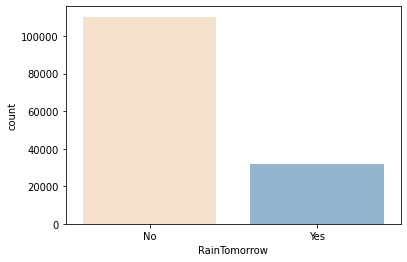

In [7]:
# overall count plot of RainTomorrow
cols= ["#fbe0c4","#8ab6d6"]
sns.countplot(x= df["RainTomorrow"], palette= cols)

In Australia, there are no rains in most days of a year.

In [8]:
location = df['Location'].unique()
#first convert this 'date' column into datetime type
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
# df = df.set_index('Date')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,2008,12
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12


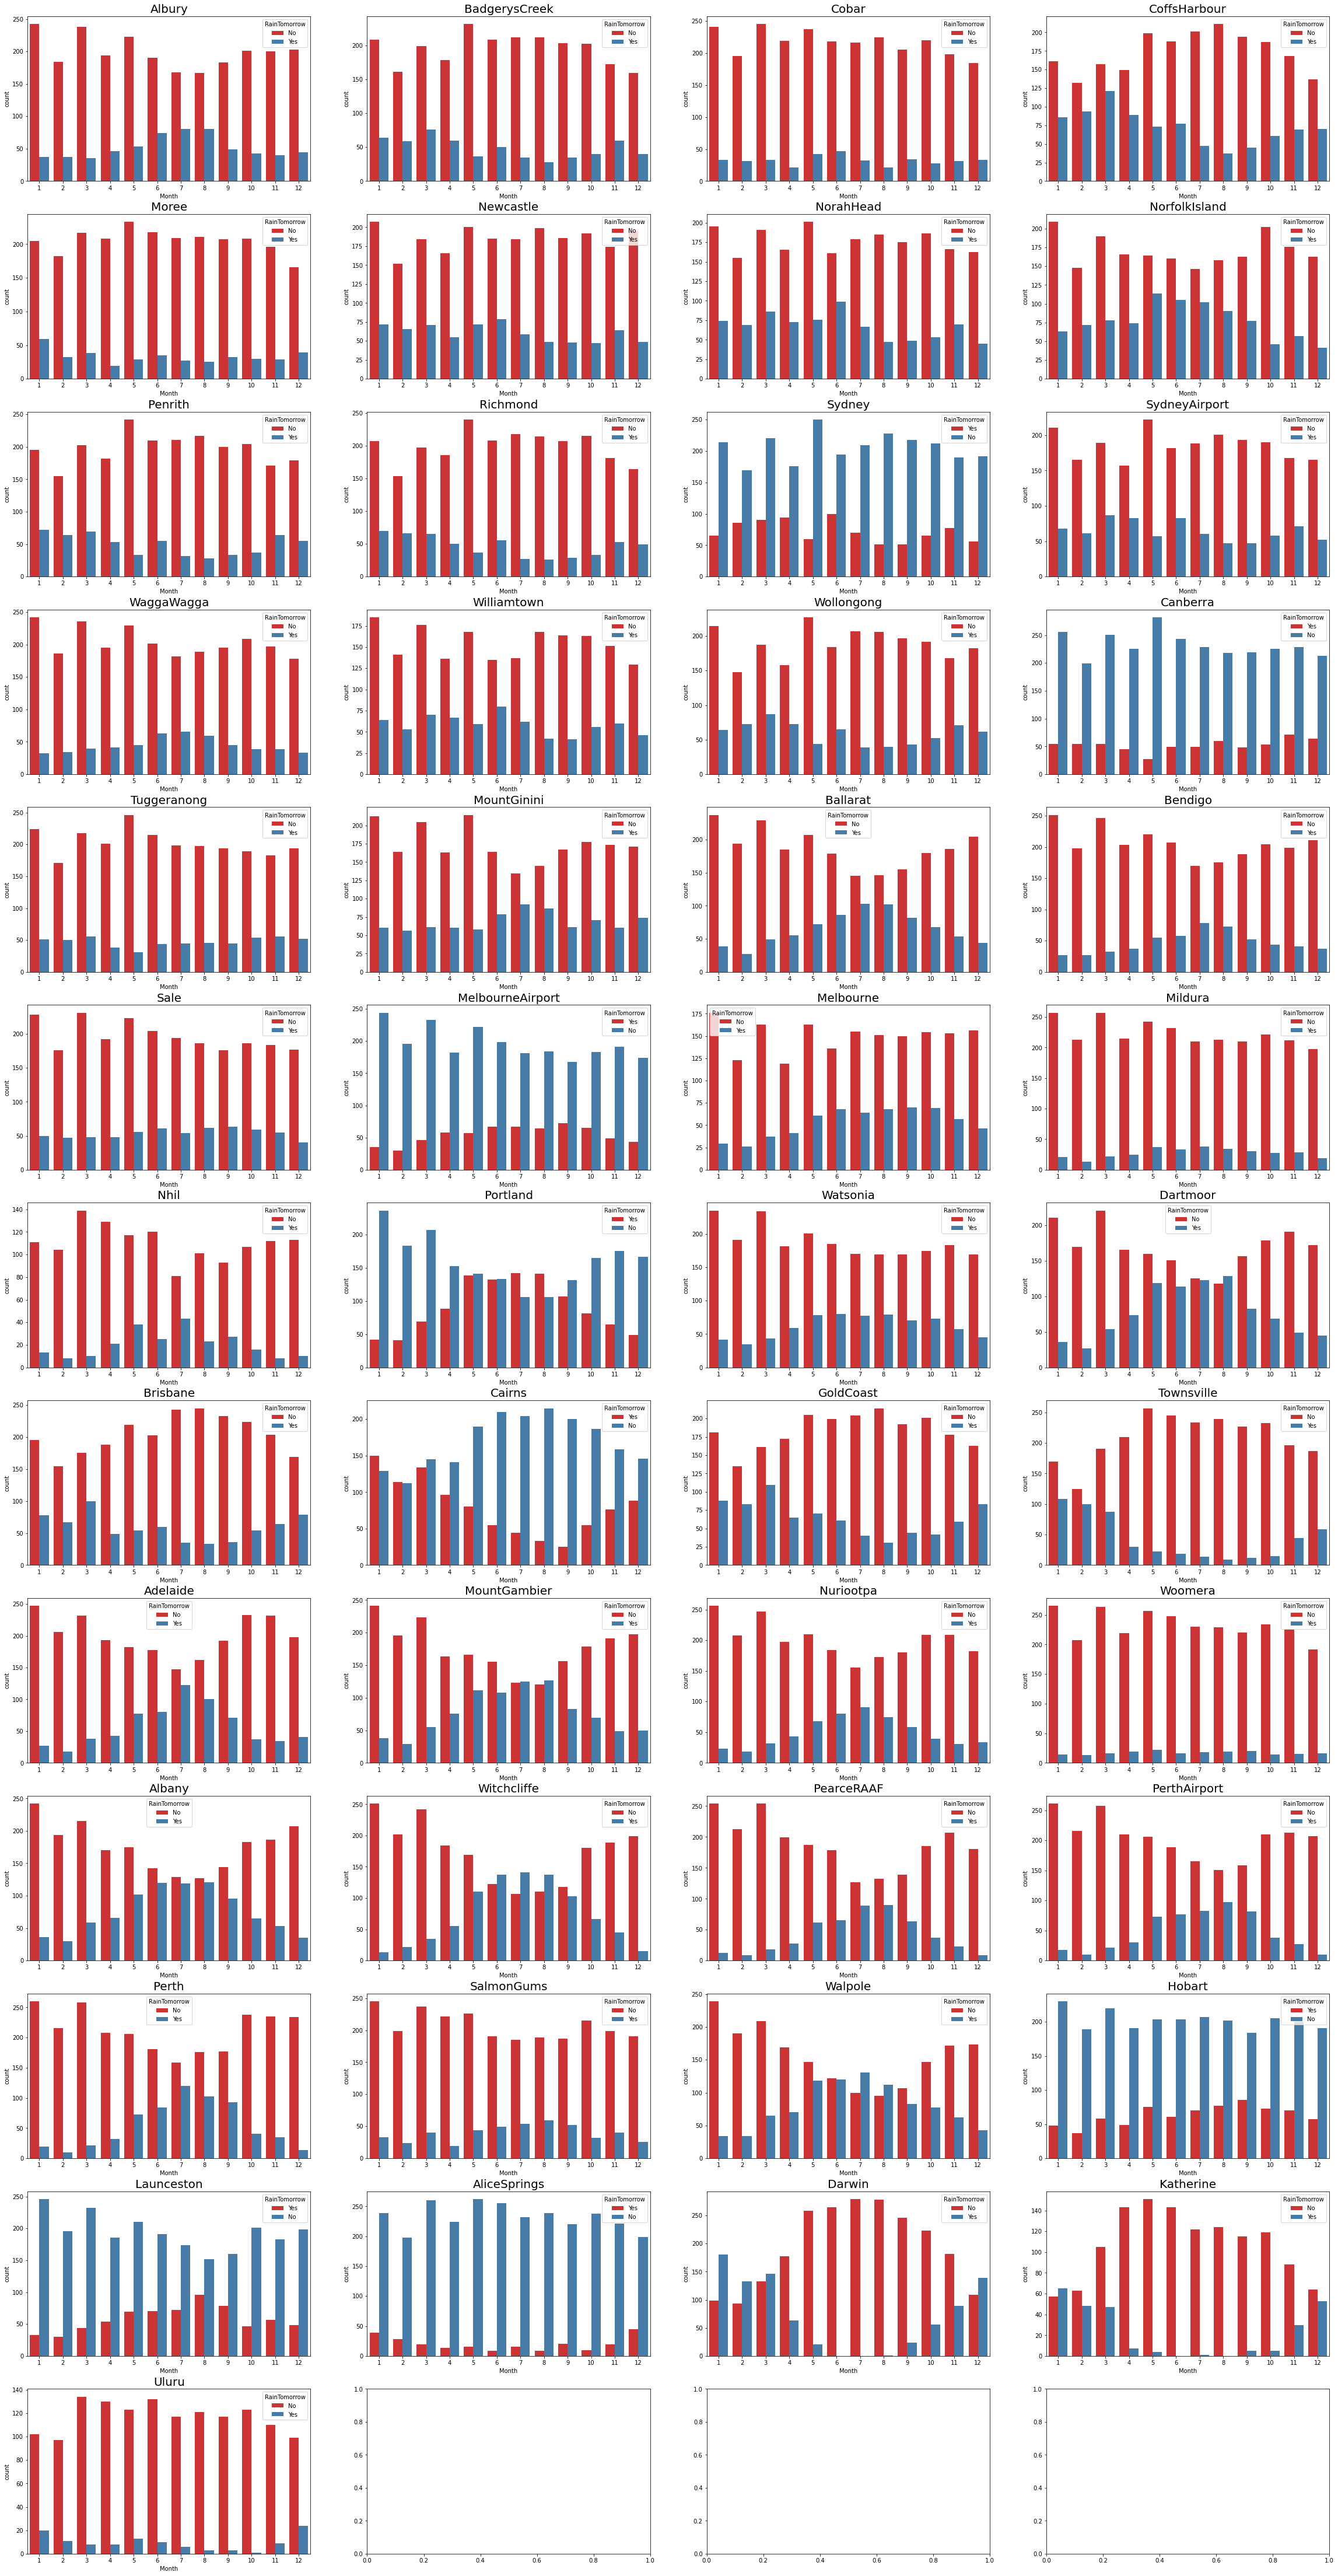

In [9]:
#  we draw the plots of the count of rains in different cities by month, with a for loop
fig, axes = plt.subplots(13,4,figsize=(40, 80))
for i,col in enumerate(location):
  plt_col = i%4
  plt_row = math.floor(i/4)
  sns.set_palette('Set1')
  ax = sns.countplot(ax = axes[plt_row,plt_col], x = 'Month', hue = 'RainTomorrow',
                 data = df[df['Location'] == col])
  ax.set_title( col,size = 20 )

From those distribution plots, we can notice an interesting phenonmenon.  Some cities have more rain days in summer ex.WitchCliffe(10,2), some cities have average rain days through the year, ex. Canberra(4,4); and some cities have more rain during Winter, ex. Darwin(-2,3).

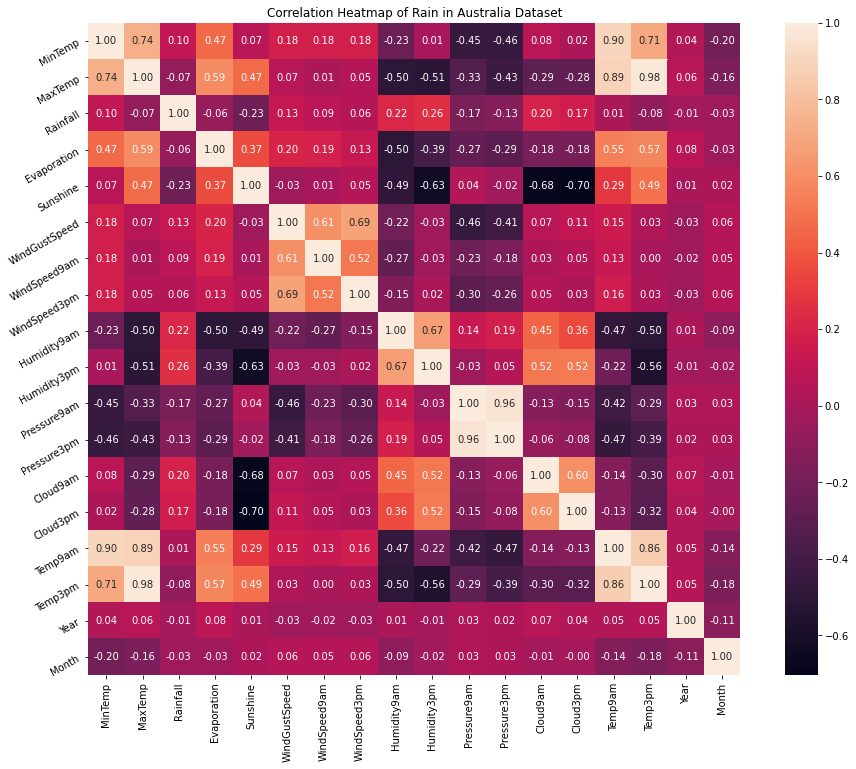

In [10]:
# heatmap
correlation = df.corr()
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Rain in Australia Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

This is heat map that indicates the correlation of variables. For the variable rainfall, it has close relationship with sunshine, humidy, and cloud.

## Data Preprocessing

In this section we will pre-process the dataset in order to build better model

### Fill in missing values

For categorical variables, filling missing values with mode of the column value. 

In [11]:
# Get list of categorical variables
s = (df.dtypes == "object")
object_cols = list(s[s].index)
# Missing values in categorical variables
for i in object_cols:
    print(i, df[i].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [12]:
# Filling missing values with mode of the column in value
for i in object_cols:
    df[i].fillna(df[i].mode()[0], inplace=True)

For numerical variables filling missing values with median of the column value.

In [13]:
# Get list of neumeric variables
t = (df.dtypes == "float64")
num_cols = list(t[t].index)
# Missing values in numeric variables

for i in num_cols:
    print(i, df[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609


In [14]:
# Filling missing values with median of the column in value

for i in num_cols:
    df[i].fillna(df[i].median(), inplace=True)

Now check the filled dataset

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  object        
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  object        
 10  WindDir3pm     145460 non-null  object        
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

### Label encoding columns with categorical data


In [16]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    df[i] = label_encoder.fit_transform(df[i])

check the labeled dataset

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  int64         
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  int64         
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  int64         
 10  WindDir3pm     145460 non-null  int64         
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

### Perform the scaling of the features

In [18]:
# Prepairing attributes of scale data

features = df.drop(['RainTomorrow','Year', 'Date','Month'], axis=1, inplace = False) # dropping target and extra columns

target = df['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,145460.0,-5.633017e-14,1.000003,-1.672228,-0.899139,0.014511,0.857881,1.701250
MinTemp,145460.0,-4.243854e-15,1.000003,-3.250525,-0.705659,-0.030170,0.723865,3.410112
MaxTemp,145460.0,6.513740e-16,1.000003,-3.952405,-0.735852,-0.086898,0.703133,3.510563
Rainfall,145460.0,9.152711e-15,1.000003,-0.275097,-0.275097,-0.275097,-0.203581,43.945571
Evaporation,145460.0,1.352327e-14,1.000003,-1.629472,-0.371139,-0.119472,0.006361,43.985108
Sunshine,145460.0,-4.338304e-15,1.000003,-2.897217,0.076188,0.148710,0.257494,2.360634
WindGustDir,145460.0,1.864381e-14,1.000003,-1.724209,-0.872075,0.193094,1.045228,1.471296
WindGustSpeed,145460.0,-1.167921e-14,1.000003,-2.588407,-0.683048,-0.073333,0.460168,7.243246
WindDir9am,145460.0,-7.433272e-15,1.000003,-1.550000,-0.885669,0.000105,0.885879,1.771653
WindDir3pm,145460.0,1.791486e-15,1.000003,-1.718521,-0.837098,0.044324,0.925747,1.586813


### Drop the Outliers

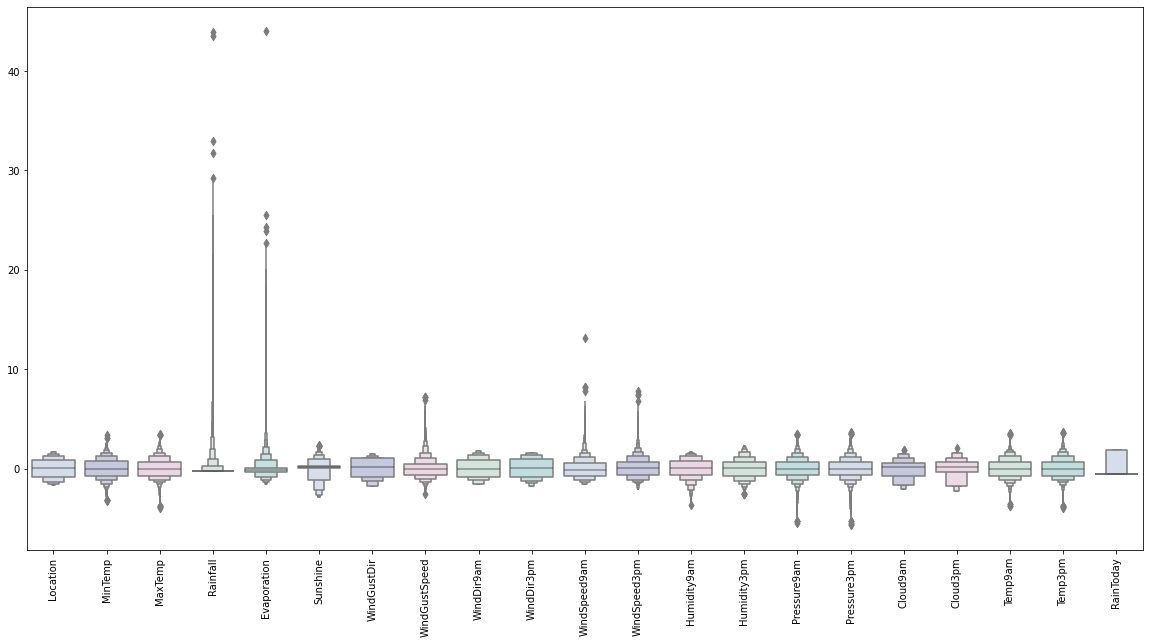

In [19]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [20]:
#full data for 
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(127536, 22)

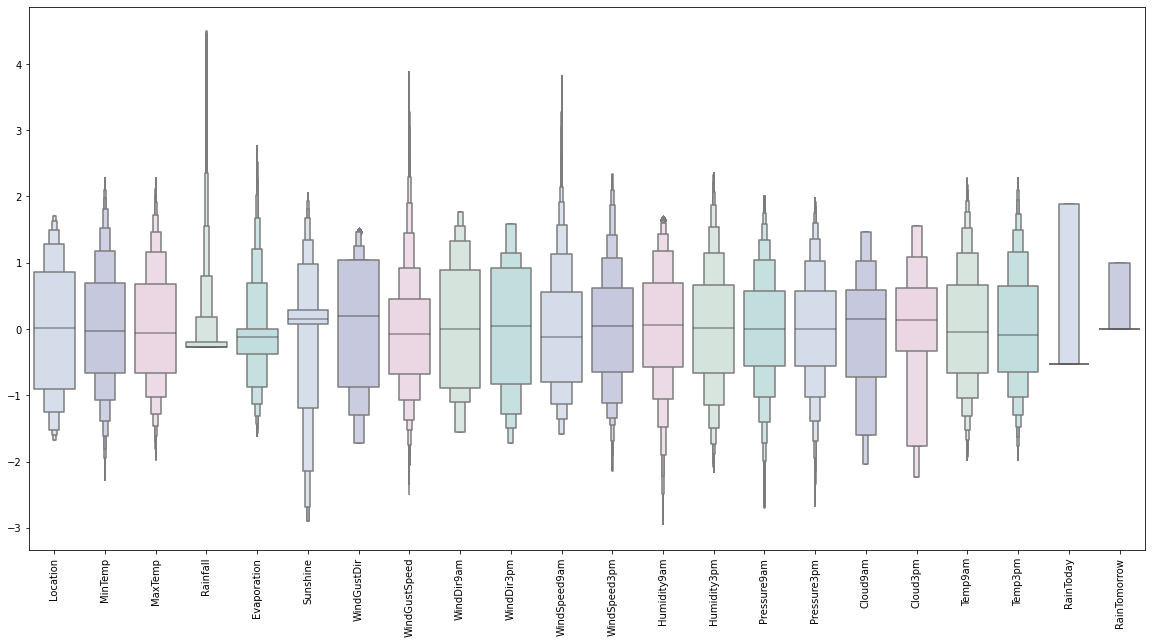

In [21]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

## ANN

### Model Building

In [22]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(127536, 21)

In [23]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 21))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
2551/2551 [==============================] - 5s 2ms/step - loss: 0.5793 - accuracy: 0.7822 - val_loss: 0.4008 - val_accuracy: 0.7860
Epoch 2/150
2551/2551 [==============================] - 4s 2ms/step - loss: 0.4376 - accuracy: 0.7827 - val_loss: 0.3926 - val_accuracy: 0.7860
Epoch 3/150
2551/2551 [==============================] - 4s 2ms/step - loss: 0.4240 - accuracy: 0.7828 - val_loss: 0.3898 - val_accuracy: 0.7860
Epoch 4/150
2551/2551 [==============================] - 4s 2ms/step - loss: 0.4198 - accuracy: 0.7827 - val_loss: 0.3885 - val_accuracy: 0.7860
Epoch 5/150
2551/2551 [==============================] - 4s 2ms/step - loss: 0.4201 - accuracy: 0.7822 - val_loss: 0.3874 - val_accuracy: 0.7860
Epoch 6/150
2551/2551 [==============================] - 4s 2ms/step - loss: 0.4212 - accuracy: 0.7826 - val_loss: 0.3870 - val_accuracy: 0.7860
Epoch 7/150
2551/2551 [==============================] - 4s 2ms/step - loss: 0.4126 - accuracy: 0.7851 - val_loss: 0.3862 - val_ac

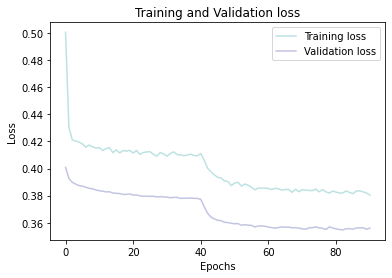

In [24]:
# plot the training and validation loss with epochs
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

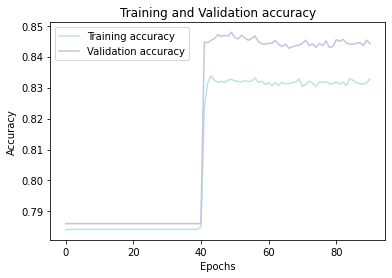

In [25]:
# plot the training and validation accuracy with epochs
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Accuracy goes to 84% rapidly, and then stays stable.



### Evaluation

In [26]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     20110
           1       0.76      0.42      0.54      5398

    accuracy                           0.85     25508
   macro avg       0.81      0.69      0.73     25508
weighted avg       0.84      0.85      0.83     25508



With ANN, we got a good accuracy, about 85%.

## Logistic Regression

In [28]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
predicted=model.predict(X_test)

conf = confusion_matrix(y_test, predicted)
print ("The accuracy of Logistic Regression is : ", accuracy_score(y_test, predicted)*100, "%")
print()
print("F1 score for logistic regression is :",f1_score(y_test, predicted,)*100, "%")

The accuracy of Logistic Regression is :  84.41273326015367 %

F1 score for logistic regression is : 56.12447583314941 %


## RandomForest

In [29]:
model = RandomForestRegressor(n_estimators = 100, random_state = 0)  
model.fit(X_train, y_train)  
predicted = model.predict(X_test)
print("The accuracy of Random Forest is : ", accuracy_score(y_test, predicted.round())*100, "%")

The accuracy of Random Forest is :  85.40065861690451 %


## Conclusion

Seen from above experiments, three models got similar accuracy in predicting on if it will rain tomorrow in Australia, but ANN gets better F1(precision) score.

# Part 2 Rainfall

Location = Darwin City

## Data Preprocessing

In [30]:
data = pd.read_csv('weatherAUS.csv')
Darwin = data[data['Location'] == 'Darwin'].copy()
# Filling missing values with mode of the column in value
for i in object_cols:
    Darwin[i].fillna(Darwin[i].mode()[0], inplace=True)
# Filling missing values with median of the column in value
for i in num_cols:
    Darwin[i].fillna(Darwin[i].median(), inplace=True)
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    Darwin[i] = label_encoder.fit_transform(Darwin[i])
Darwin= Darwin.drop(['Date','Location'], axis = 1)
Darwin.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
139111,20.0,33.1,0.0,4.4,11.0,0,41.0,1,10,13.0,17.0,81.0,32.0,1016.0,1012.1,1.0,2.0,25.4,32.3,0,0
139112,19.4,32.4,0.0,6.0,10.4,1,50.0,9,0,15.0,28.0,81.0,17.0,1016.8,1012.4,1.0,1.0,24.3,31.9,0,0
139113,18.2,31.8,0.0,8.0,11.0,0,46.0,2,1,22.0,19.0,38.0,24.0,1017.2,1013.0,0.0,1.0,24.3,31.2,0,0
139114,17.3,30.7,0.0,7.0,10.4,0,44.0,9,0,22.0,13.0,55.0,16.0,1017.3,1013.6,2.0,6.0,21.3,29.8,0,0
139115,15.5,30.8,0.0,7.0,10.8,2,46.0,0,0,20.0,19.0,37.0,16.0,1016.3,1012.6,1.0,1.0,22.2,29.6,0,0


## Random Forest

In [31]:

cols_need = ['Sunshine', 'Humidity9am', 'Humidity3pm', 'Cloud9am', 'Cloud3pm','Pressure9am','Pressure3pm']
X = Darwin[cols_need]
y = Darwin['Rainfall']
X, y

(        Sunshine  Humidity9am  Humidity3pm  ...  Cloud3pm  Pressure9am  Pressure3pm
 139111      11.0         81.0         32.0  ...       2.0       1016.0       1012.1
 139112      10.4         81.0         17.0  ...       1.0       1016.8       1012.4
 139113      11.0         38.0         24.0  ...       1.0       1017.2       1013.0
 139114      10.4         55.0         16.0  ...       6.0       1017.3       1013.6
 139115      10.8         37.0         16.0  ...       1.0       1016.3       1012.6
 ...          ...          ...          ...  ...       ...          ...          ...
 142299       8.6         56.0         28.0  ...       0.0       1014.6       1011.2
 142300      11.0         46.0         23.0  ...       0.0       1015.3       1011.8
 142301      10.6         62.0         58.0  ...       1.0       1014.9       1010.7
 142302      10.7         73.0         32.0  ...       5.0       1013.9       1009.7
 142303      10.0         68.0         45.0  ...       1.0       

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
model = RandomForestRegressor(n_estimators = 100, random_state = 0)  
model.fit(X_train, y_train)  
predicted = model.predict(X_test)
# print("The accuracy of Random Forest is : ", accuracy_score(y_test, predicted.round())*100, "%")

In [35]:
# Get R2 measure (indicator of accuracy 1 is perfect, 0 is horrible)
model.score(X_test, y_test)

0.36632342633783577

Poor accuracy, but make sense. Because to predict accurate rainfall volumn is much harder than to predict if it will rain tommorow  or not.

## Bayesian Regression Estimation



In [38]:
with pm.Model() as glm_model:
    pm.glm.GLM.from_formula('Rainfall ~ Humidity3pm + Cloud9am + WindGustSpeed + Pressure9am',
                            Darwin,
                            family=pm.glm.families.Normal())
    trace2 = pm.sample(1000, tune=1000, init='adapt_diag', cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, Pressure9am, WindGustSpeed, Cloud9am, Humidity3pm, Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [10:23<00:00,  3.21it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0394c3e90>,
      dtype=object)

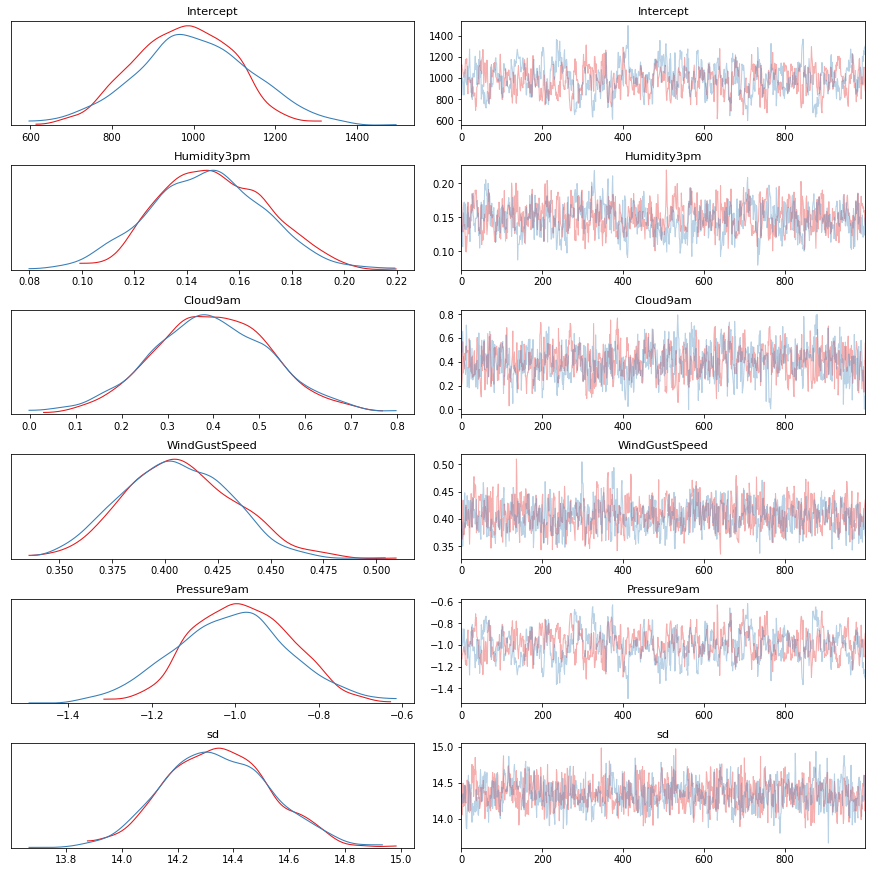

In [39]:
pm.traceplot(trace2)

/usr/local/lib/python3.7/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc036a66350>,
      dtype=object)

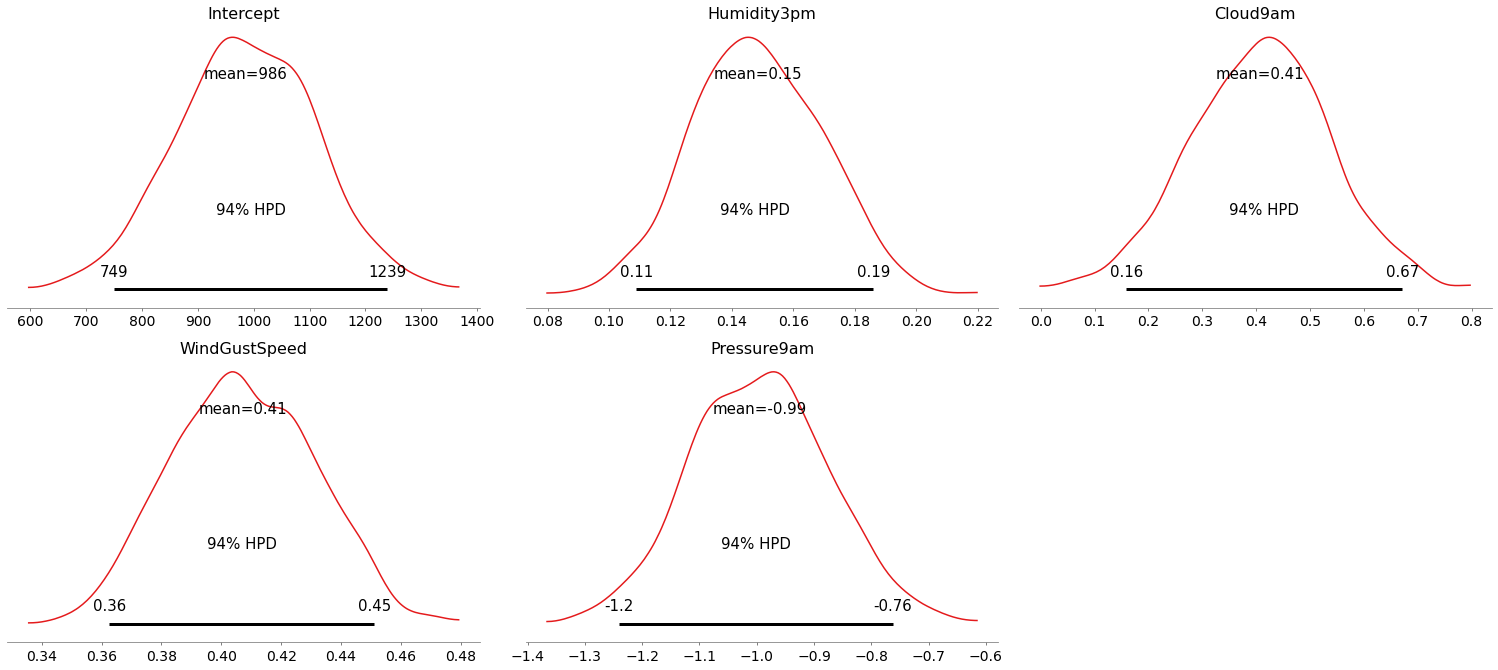

In [40]:
pm.plot_posterior(trace2[500:], varnames=['Intercept', 'Humidity3pm', 'Cloud9am', 'WindGustSpeed', 'Pressure9am'])

So, with Bayesian analysis, we have the relationship formula:

RainFall = 986 + 0.15 * Humidity3pm + 0.41 * Cloud9am + 0.41 * WindGustSpeed - 0.99 * Pressure9am

In comparison, the data modeling and prediction performs better with rainTomorrow (yes/no) than rainFall (capacity).

### Thank you!